In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/NLP/WordSmi/Word2Vec
!pip install pyvi
!pip install overrides
import pickle as cPickle   
from tqdm import tqdm
import numpy as np 
import random
import os
from pyvi import ViTokenizer 

/content/drive/My Drive/NLP/WordSmi/Word2Vec
     |████████████████████████████████| 8.5MB 3.2MB/s 
     |████████████████████████████████| 747kB 39.0MB/s 
  Created wheel for overrides: filename=overrides-3.1.0-cp36-none-any.whl size=10174 sha256=59672c3458f1390129f69b29be7cbbce79ee7a34e51631321001fb124af98799
  Stored in directory: /root/.cache/pip/wheels/5c/24/13/6ef8600e6f147c95e595f1289a86a3cc82ed65df57582c65a9
Successfully built overrides


In [3]:

class FileStore(object):
    def __init__(self, file_path, data = None):
        self.file_path = file_path
        self.data = data

    def store_json(self):
        print("Save: ",self.file_path)
        with open(self.file_path, 'w') as outfile:
            json.dump(self.data, outfile)

    # store dictionary: https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes
    # dict_word là mãng chữa các đoạn text đã được segmentation [[cá, con, ăn],[con, mèo],[con, chó, chạy, qua]]
    # len của dictionary sẽ là 7 
    # no_above là tần suất xuất hiện trên số phần trăm ví dụ: no_above = 0.5 là tần suất xuất hiện không được trên (phải dưới) của tổng số tài liệu 50%
    # no_below là số lần xuất hiện không được dưới ... ví dụ no_below = 2 là số lần xuất hiện trong từng tài liệu không được dưới 2
    def store_dictionary(self, dict_words):
        dictionary = corpora.Dictionary(dict_words)
        dictionary.filter_extremes(no_below=170, no_above=0.3) 
        dictionary.save_as_text(self.file_path)
 

    def save_pickle(self,  obj):
        outfile = open(self.file_path, 'wb')
        fastPickler = cPickle.Pickler(outfile, 4)
        fastPickler.fast = 1
        fastPickler.dump(obj)
        outfile.close()

In [4]:
# tạo class đọc file 
class FileReader(object):
    def __init__(self, file_path, encoder = None):
        self.file_path = file_path
        self.encoder = encoder if encoder != None else 'utf-16le'

    def read(self):
        with open(self.file_path,'rb',encoding ='utf-8') as f:
            s = f.read() 
        return s

    def content(self):
        s = self.read() 
        return s.decode(self.encoder)

    def read_json(self):
        with open(self.file_path) as f:
            s = json.load(f)
        return s
        
    def read_stopwords(self):
        with open(self.file_path, 'r',encoding ='utf-8') as f:
            stopwords = set([w.strip().replace(' ', '_') for w in f.readlines()])
        return stopwords
      
    def load_estimator(self): 
        with open(self.file_path, mode='rb') as f:
            estimator = cPickle.load(f)
            f.close()
        return estimator

In [5]:
DATA_TRAIN_JSON = '/content/drive/My Drive/NLP/WordSmi/ELMO/dataset/train.json'
STOP_WORDS = '/content/drive/My Drive/NLP/WordSmi/ELMO/dataset/stopwords-nlp-vi.txt'
SPECIAL_CHARACTER = '0123456789%@$.,=+-!;/()*"&^:#|\n\t\''
DICTIONARY_PATH = '/content/drive/My Drive/NLP/nlp_me/dictionary.txt'

Đọc file train

In [6]:
# xây dựng class NLP extends từ pyvi để extract feature 
class NLP(object):
    def __init__(self, text = None):
        self.text = text
        self.__set_stopwords()

    #đọc file stop_word đã chứa sẵn trong đường dẫn
    def __set_stopwords(self):
        self.stopwords = FileReader(STOP_WORDS).read_stopwords()

    # vì trong câu sẽ xuất hiện rất nhiều từ vô nghĩa, sẽ làm noise dữ liệu cho nên phải segmentation trước khi train. Sử dụng ViTokenizer từ Pyvi 
    # để tokenize (đây là một model do người việt đã làm để segmentation tiếng việt)
    def segmentation(self):
        return ViTokenizer.tokenize(self.text)

    # loại bỏ kí tự đặc biệt, lowercase và segmentation tiếng việt
    def split_words(self):
        text = self.segmentation()
        try:
            return [x.strip(SPECIAL_CHARACTER).lower() for x in text.split()]
        except TypeError:
            return []

    # get feature trong câu gồm hai bước 
    # loại bỏ kí tự đặc biệt và loại bỏ stop_words - stop_word là những từ vô nghĩa không mang lại hiệu quả train 
    def get_words_feature(self):
        split_words = self.split_words()
        return [word for word in split_words if word.encode('utf-8') not in self.stopwords]


In [ ]:
word_not_in_vocab = []
class FeatureExtraction(object):
    def __init__(self, data=None, build_dic=False):
        self.data = data
        self.build_dic = build_dic

    # build từ điển gồm các từ xuất hiện trong văn bản sau khi đã preprocess dữ liệu 
    def __build_dictionary(self):
        print('Building dictionary')
        dict_words = []  
        for i in tqdm(range(len(self.data)), desc='build dictionary'): 
            if self.data[i]['category'].split('.')[0] != 'My': 
                words = NLP(text = self.data[i]['content']).split_words()
                dict_words.append(words)  
        FileStore(file_path=DICTIONARY_PATH).store_dictionary(dict_words)

    # load từ điển đã xây dựng theo dữ liệu train
    def __load_dictionary(self):
        if os.path.exists(DICTIONARY_PATH) == False or self.build_dic == True: 
            print("Dictionary is not exist")
            self.__build_dictionary() 
            self.build_dic = False
        
        self.dictionary = FileReader(DICTIONARY_PATH).load_dictionary()
    # extract feature từ từ điển đã tạo cùng với label
    # x sẽ là word2vec, y là label
    def __build_dataset(self):
        self.features = []
        self.labels = [] 
        error = 0
        for i in tqdm(range(len(self.data)), desc='build dataset'): 
            try:
                content = self.get_dense(self.data[i]['content'])
                self.features.append(content)
                self.labels.append(self.data[i]['category'])
            except:
                print("error",error)
                error+=1
                continue 
        print('Total:',error,'paragraph')

    def get_dense(self, text):
        words = NLP(text).get_words_feature()
        vec = []
        for w in words:
            try:
                vec.append(word2vec_model[w])
            except:
                if w not in word_not_in_vocab:
                    word_not_in_vocab.append(w)
        return np.sum(vec, axis=0)

    def get_data_and_label(self):
        print("** Start build dataset")
        self.__build_dataset()  
        return self.features, self.labels

In [ ]:
import json

train_loader = FileReader(file_path=DATA_TRAIN_JSON) 
data_train_raw = train_loader.read_json()
print('Total data train: %d' %len(data_train_raw))
random.shuffle(data_train_raw)

Total data train: 105800


In [ ]:
dic = dict() 
dic_count = dict()
NUM_RANDOM = random.randint(2000,2500) 
for item in data_train_raw:
    if item['category'] not in dic.keys():
        dic[item['category']] = NUM_RANDOM
        dic_count[item['category']] = 0
    if len(dic.keys()) > 11:
        break

In [ ]:
data_train = []
for i in tqdm(range(len(data_train_raw)), desc='build dataset'): 
    item = data_train_raw[i]
    try:
        if dic[item['category']] > dic_count[item['category']]: 
            data_train.append(item)
            dic_count[item['category']]+=1
    except:
        continue

build dataset: 100%|██████████| 105800/105800 [00:00<00:00, 899691.15it/s]


In [ ]:
print(len(data_train))

28944


In [ ]:
import codecs
import gensim
import os

from distutils.version import LooseVersion, StrictVersion

model = 'model/baomoi.model.bin'

if os.path.isfile(model):
    print('Loading word2vec model ...')
    if LooseVersion(gensim.__version__) >= LooseVersion("1.0.1"):
        from gensim.models import KeyedVectors
        word2vec_model = KeyedVectors.load_word2vec_format(model, binary=True)
    else:
        from gensim.models import Word2Vec
        word2vec_model = Word2Vec.load_word2vec_format(model, binary=True)

        app.run(port=8089)
else:
    print("Download word2vec model and put into ./data/. File: https://drive.google.com/open?id=0B1GKSX6YCHXlakkzQ2plZVdUUE0")


Loading word2vec model ...


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
query = "yêu_đời"
word2vec_model[query].shape

(400,)

In [ ]:
# try:
output = []
sim_list = word2vec_model.most_similar(query, topn=50)
#output = word2vec_model.most_similar('u' + '\"' + query + '\"', topn=5)
for wordsimilar in sim_list:
    # output[wordsimilar[0]] = wordsimilar[1]
    output.append(wordsimilar[0] + ' - '+ str(wordsimilar[1]))
    # file = codecs.open("output.txt", "a", "utf-8")
    # file.write(wordsimilar[0] + "\t" + str(wordsimilar[1]) + "\n")
    # file.close()
# exceoutput = 'Not found' + query
    
print(output)

['tươi_vui - 0.6415250897407532', 'phấn_chấn - 0.6185187101364136', 'hoạt_bát - 0.5687282085418701', 'vui_vẻ - 0.5604209899902344', 'phơi_phới - 0.5565494894981384', 'vui_tươi - 0.5514799356460571', 'tươi_trẻ - 0.5471391677856445', 'thanh_thản - 0.5283610224723816', 'thư_thái - 0.5135704278945923', 'tươi_tắn - 0.5111798048019409', 'tươi_tỉnh - 0.5072929859161377', 'hăng_say - 0.5022311806678772', 'rạo_rực - 0.49628326296806335', 'khỏe_khoắn - 0.49231481552124023', 'tràn_đầy - 0.4911952614784241', 'vui_tính - 0.4880105257034302', 'sảng_khoái - 0.4871392250061035', 'minh_mẫn - 0.4856101870536804', 'rắn_rỏi - 0.4804350435733795', 'cứng_cỏi - 0.4753692150115967', 'tráng_kiện - 0.47459495067596436', 'trầm_tĩnh - 0.47308027744293213', 'ngời_sáng - 0.4708581864833832', 'trong_trẻo - 0.4699096381664276', 'hồn_nhiên - 0.46882152557373047', 'trẻ_trung - 0.46811094880104065', 'ấm_áp - 0.4674622714519501', 'đằm_thắm - 0.4665767550468445', 'vững_tâm - 0.46642324328422546', 'an_nhiên - 0.46389240026

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
from tqdm.notebook import tqdm
features_train, labels_train = FeatureExtraction(data=data_train).get_data_and_label() 

** Start build dataset



Total: 0 paragraph


In [ ]:
# # load data hơi lâu nên để hai biến giữ lại data ban dầu  
x, y = np.array(features_train),np.array(labels_train)
np.save('/content/drive/My Drive/NLP/WordSmi/Word2Vec/data/x_full.npy', x) 
np.save('/content/drive/My Drive/NLP/WordSmi/Word2Vec/data/y_full.npy', y) 

In [7]:

x = np.load('/content/drive/My Drive/NLP/WordSmi/Word2Vec/data/x_full.npy') 
y = np.load('/content/drive/My Drive/NLP/WordSmi/Word2Vec/data/y_full.npy')

In [ ]:
# from sklearn import preprocessing
# x = preprocessing.scale(x)

In [8]:
from keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder
# encode label  

# mlb = FileReader(file_path=LABEL_ENCODE_PATH).load_estimator()
mlb = LabelEncoder()
k = mlb.fit_transform(y)
# one hot encoding 
y = to_categorical(k)

Using TensorFlow backend.


In [9]:
from sklearn.model_selection import train_test_split
# chia tập train, test theo tỉ lệ 8:2   
(x_train,x_test, y_train, y_test) = train_test_split(x, y, test_size=0.2, random_state=43)
y_train.shape

(23155, 12)

In [10]:
print('Shape features:',"Total document",y_train.shape[0] + y_test.shape[0],"- Size matrix train (size dictionary)",x_train.shape)
print('Train set',y_train.shape[0],'docs') 
print('Test set',y_test.shape[0],'docs') 
print("Shape",x.shape,y.shape)
SIZE_TRAIN = x_train.shape[1]
y_test[0]


Shape features: Total document 28944 - Size matrix train (size dictionary) (23155, 400)
Train set 23155 docs
Test set 5789 docs
Shape (28944, 400) (28944, 12)


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [11]:
print("- tổng số label:")
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label)) 

- tổng số label:
1. Chia_se_kien_thuc
2. Doanh_nghiep
3. Du_lich
4. Giai_tri
5. Giao_duc
6. Suc_khoe
7. Tai_chinh_quoc_te
8. The_thao
9. Thi_truong_chung_khoan
10. Tin_tuc
11. Van_hoa
12. Xe


In [ ]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras import backend as K
from keras.optimizers import Adam, SGD 
from keras.layers import LeakyReLU
from sklearn.metrics import classification_report
# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras import Sequential

# xây dựng mạng network
class ModelNLP(object):
  @staticmethod
  def build(SIZE_TRAIN,num_classes, final_activation):
    model = Sequential()
    model.add(Dense(700, input_shape=(SIZE_TRAIN,), activation='relu', kernel_initializer="uniform")) 
    model.add(LeakyReLU(alpha=0.3))        
    model.add(Dropout(rate=0.2)) 
    model.add(Dense(600))      
    model.add(LeakyReLU(alpha=0.3))  
    model.add(Dropout(rate=0.2)) 
    model.add(Dense(500))      
    model.add(LeakyReLU(alpha=0.3))        
    model.add(Dropout(rate=0.2))
    model.add(Dense(400))      
    model.add(LeakyReLU(alpha=0.3))        
    model.add(Dropout(rate=0.2))
    model.add(Dense(300))    
    model.add(Dense(num_classes, activation=final_activation))
  
    return model
# !pip install tensorflow==1.14
# khởi tạo model
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

model = ModelNLP.build(SIZE_TRAIN=SIZE_TRAIN,num_classes=len(mlb.classes_),final_activation='softmax')
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

sgd = SGD(lr=0.001); 
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 700)               280700    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 700)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 600)               420600    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 600)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)              

In [ ]:
# training 
H = model.fit(x_train, y_train, validation_data= (x_test,y_test),epochs=40, verbose=1)

Train on 23155 samples, validate on 5789 samples
Epoch 1/40
23155/23155 [==============================] - 7s 287us/step - loss: 1.3718 - accuracy: 0.8972 - val_loss: 0.9150 - val_accuracy: 0.9316
Epoch 2/40
23155/23155 [==============================] - 5s 207us/step - loss: 0.8891 - accuracy: 0.9323 - val_loss: 0.6217 - val_accuracy: 0.9511
Epoch 3/40
23155/23155 [==============================] - 5s 208us/step - loss: 0.6906 - accuracy: 0.9467 - val_loss: 0.5293 - val_accuracy: 0.9594
Epoch 4/40
23155/23155 [==============================] - 5s 207us/step - loss: 0.6143 - accuracy: 0.9528 - val_loss: 0.5353 - val_accuracy: 0.9592
Epoch 5/40
23155/23155 [==============================] - 5s 208us/step - loss: 0.5836 - accuracy: 0.9553 - val_loss: 0.5085 - val_accuracy: 0.9605
Epoch 6/40
23155/23155 [==============================] - 5s 210us/step - loss: 0.5508 - accuracy: 0.9572 - val_loss: 0.4370 - val_accuracy: 0.9663
Epoch 7/40
23155/23155 [==============================] - 5s 21

In [ ]:
# evaluate 
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100)) 

Test Accuracy: 97.369963


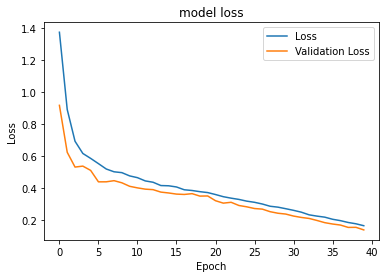

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [ ]:
  
LABEL_ENCODE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Word2Vec/lb_elmo_nn.pkl"
ESTIMATE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Word2Vec/estimator_elmo_nn.h5"
FileStore(file_path=LABEL_ENCODE_PATH).save_pickle(obj=mlb)
FileStore(file_path=ESTIMATE_PATH).save_pickle(obj=model)

from keras.models import save_model, load_model

# Creates a HDF5 file 'ESTIMATE_PATH.h5' 
save_model(model, ESTIMATE_PATH) 

LSTMModel

In [ ]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers import LSTM
from keras import backend as K
from keras.optimizers import Adam, SGD 
from keras.layers import LeakyReLU
from sklearn.metrics import classification_report
class LSTMModel(object): 
  @staticmethod
  def build(SIZE_TRAIN,num_classes, final_activation):    
    # define model
    model = Sequential()
    model.add(LSTM(100,input_shape=(SIZE_TRAIN,1), activation='tanh', dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(50))
    model.add(Dense(num_classes, activation=final_activation)) 
    return model 

    
# khởi tạo model
EPOCHS = 20
INIT_LR = 1e-3
BS = 32 
n_features = 1

model_lstm = LSTMModel.build(SIZE_TRAIN=SIZE_TRAIN,num_classes=len(mlb.classes_),final_activation='softmax')
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
sgd = SGD(lr=0.001); 
model_lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_lstm.summary() 
 


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_10 (Dense)             (None, 12)                612       
Total params: 46,462
Trainable params: 46,462
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train.shape

(23155, 400, 1)

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],1))
H = model_lstm.fit(x_train, y_train, validation_data= (x_test,y_test),epochs=30, verbose=1, batch_size=512)

Train on 23155 samples, validate on 5789 samples
Epoch 1/30
23155/23155 [==============================] - 62s 3ms/step - loss: 0.2671 - accuracy: 0.9167 - val_loss: 0.2437 - val_accuracy: 0.9167
Epoch 2/30
23155/23155 [==============================] - 62s 3ms/step - loss: 0.2420 - accuracy: 0.9185 - val_loss: 0.2241 - val_accuracy: 0.9210
Epoch 3/30
23155/23155 [==============================] - 62s 3ms/step - loss: 0.2285 - accuracy: 0.9215 - val_loss: 0.2062 - val_accuracy: 0.9254
Epoch 4/30
23155/23155 [==============================] - 61s 3ms/step - loss: 0.2192 - accuracy: 0.9238 - val_loss: 0.1973 - val_accuracy: 0.9280
Epoch 5/30
23155/23155 [==============================] - 62s 3ms/step - loss: 0.2122 - accuracy: 0.9262 - val_loss: 0.1906 - val_accuracy: 0.9305
Epoch 6/30
23155/23155 [==============================] - 62s 3ms/step - loss: 0.2060 - accuracy: 0.9281 - val_loss: 0.1846 - val_accuracy: 0.9319
Epoch 7/30
23155/23155 [==============================] - 65s 3ms/ste

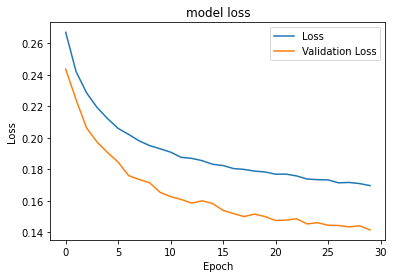

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [ ]:
# evaluate 
loss, acc = model_lstm.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100)) 

Test Accuracy: 94.578779


In [ ]:
LABEL_ENCODE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Word2Vec/lb_elmo_lstm.pkl"
ESTIMATE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Word2Vec/estimator_elmo_lstm.h5"
FileStore(file_path=LABEL_ENCODE_PATH).save_pickle(obj=mlb)
FileStore(file_path=ESTIMATE_PATH).save_pickle(obj=model_lstm)

from keras.models import save_model, load_model

# Creates a HDF5 file 'ESTIMATE_PATH.h5' 
save_model(model_lstm, ESTIMATE_PATH) 

CNN_LSTM_Model


In [ ]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers import LSTM
from keras import backend as K
from keras.optimizers import Adam, SGD 
from keras.layers import LeakyReLU,Conv1D,MaxPooling1D
from sklearn.metrics import classification_report
class CNN_LSTM_Model(object): 
  @staticmethod
  def build(SIZE_TRAIN,num_classes, final_activation):    
    # define model
    model = Sequential()
    model.add(Conv1D(filters=32,input_shape=(SIZE_TRAIN,1), kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(200))
    model.add(Dense(100))  
    model.add(Dense(num_classes, activation=final_activation)) 
    return model 

    
# khởi tạo model
EPOCHS = 20
INIT_LR = 1e-3
BS = 32 
n_features = 1

model_cnnlstm = CNN_LSTM_Model.build(SIZE_TRAIN=SIZE_TRAIN,num_classes=len(mlb.classes_),final_activation='softmax')
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
sgd = SGD(lr=0.001); 
model_cnnlstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_cnnlstm.summary() 
  

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 400, 32)           128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 200, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               186400    
_________________________________________________________________
dense_13 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_14 (Dense)             (None, 12)                1212      
Total params: 207,840
Trainable params: 207,840
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],n_features))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],n_features))
H = model_cnnlstm.fit(x_train, y_train, validation_data= (x_test,y_test),epochs=20, verbose=1, batch_size=512)

Train on 23155 samples, validate on 5789 samples
Epoch 1/20
23155/23155 [==============================] - 29s 1ms/step - loss: 0.2170 - accuracy: 0.9242 - val_loss: 0.1914 - val_accuracy: 0.9312
Epoch 2/20
23155/23155 [==============================] - 29s 1ms/step - loss: 0.1769 - accuracy: 0.9347 - val_loss: 0.1726 - val_accuracy: 0.9361
Epoch 3/20
23155/23155 [==============================] - 29s 1ms/step - loss: 0.1619 - accuracy: 0.9396 - val_loss: 0.1653 - val_accuracy: 0.9391
Epoch 4/20
23155/23155 [==============================] - 28s 1ms/step - loss: 0.1550 - accuracy: 0.9420 - val_loss: 0.1584 - val_accuracy: 0.9416
Epoch 5/20
23155/23155 [==============================] - 28s 1ms/step - loss: 0.1484 - accuracy: 0.9445 - val_loss: 0.1558 - val_accuracy: 0.9416
Epoch 6/20
23155/23155 [==============================] - 28s 1ms/step - loss: 0.1435 - accuracy: 0.9460 - val_loss: 0.1517 - val_accuracy: 0.9429
Epoch 7/20
23155/23155 [==============================] - 29s 1ms/ste

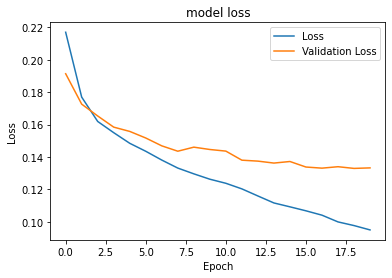

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt 
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [ ]:
# evaluate 
loss, acc = model_cnnlstm.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100)) 

# lb: label encodem 
# ft: fast text 
# sg: skip gram 
# cnn: convolution neural network 
# lstm: long short term memory 
# nn: neural network

Test Accuracy: 95.049524


In [ ]:
LABEL_ENCODE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Word2Vec/lb_elmo_cnn_lstm.pkl" 
ESTIMATE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Word2Vec/estimator_elmo_cnn_lstm.h5"
FileStore(file_path=LABEL_ENCODE_PATH).save_pickle(obj=mlb)
FileStore(file_path=ESTIMATE_PATH).save_pickle(obj=model_cnnlstm)

from keras.models import save_model, load_model

# Creates a HDF5 file 'ESTIMATE_PATH.h5' 
save_model(model_cnnlstm, ESTIMATE_PATH) 

RNN_Model


In [12]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers import LSTM
from keras import backend as K
from keras.optimizers import Adam, SGD 
from keras.layers import LeakyReLU,Conv1D,MaxPooling1D,Bidirectional
from sklearn.metrics import classification_report
class RNN_Model(object): 
  @staticmethod
  def build(SIZE_TRAIN,num_classes, final_activation):    
    # define model
    model = Sequential()
    model.add(Bidirectional(LSTM(200, activation='tanh', dropout=0.2, recurrent_dropout=0.2),input_shape=(SIZE_TRAIN,1))) 
    model.add(Dense(100))
    model.add(Dense(num_classes, activation=final_activation)) 
    return model 

    
# khởi tạo model
EPOCHS = 20
INIT_LR = 1e-3
BS = 32 
n_features = 1

model_rnn = RNN_Model.build(SIZE_TRAIN=SIZE_TRAIN,num_classes=len(mlb.classes_),final_activation='softmax')
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
sgd = SGD(lr=0.001); 
model_rnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_rnn.summary() 
  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 400)               323200    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               40100     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1212      
Total params: 364,512
Trainable params: 364,512
Non-trainable params: 0
_________________________________________________________________


In [13]:
# from sklearn import preprocessing
# x_t = preprocessing.scale(x_train.reshape((x_train.shape[0], x_train.shape[1])))

In [14]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],n_features))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],n_features))
H = model_rnn.fit(x_train, y_train, validation_data= (x_test,y_test),epochs=20, verbose=1, batch_size=512)

Train on 23155 samples, validate on 5789 samples
Epoch 1/20
23155/23155 [==============================] - 121s 5ms/step - loss: 0.2367 - accuracy: 0.9209 - val_loss: 0.2009 - val_accuracy: 0.9268
Epoch 2/20
23155/23155 [==============================] - 120s 5ms/step - loss: 0.1988 - accuracy: 0.9284 - val_loss: 0.1682 - val_accuracy: 0.9363
Epoch 3/20
23155/23155 [==============================] - 118s 5ms/step - loss: 0.1803 - accuracy: 0.9340 - val_loss: 0.1528 - val_accuracy: 0.9422
Epoch 4/20
23155/23155 [==============================] - 119s 5ms/step - loss: 0.1701 - accuracy: 0.9371 - val_loss: 0.1459 - val_accuracy: 0.9444
Epoch 5/20
23155/23155 [==============================] - 120s 5ms/step - loss: 0.1627 - accuracy: 0.9398 - val_loss: 0.1430 - val_accuracy: 0.9444
Epoch 6/20
23155/23155 [==============================] - 121s 5ms/step - loss: 0.1559 - accuracy: 0.9417 - val_loss: 0.1410 - val_accuracy: 0.9458
Epoch 7/20
23155/23155 [==============================] - 121s 

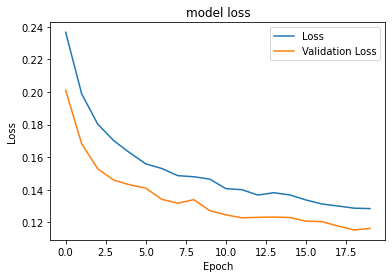

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt 
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [16]:
# evaluate 
loss, acc = model_rnn.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100)) 

# lb: label encodem 
# ft: fast text 
# sg: skip gram 
# cnn: convolution neural network 
# lstm: long short term memory 
# nn: neural network

Test Accuracy: 95.632517


In [17]:
LABEL_ENCODE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Word2Vec/lb_elmo_rnn.pkl" 
ESTIMATE_PATH="/content/drive/My Drive/NLP/WordSmi/ModelClassify/Word2Vec/estimator_elmo_rnn.h5"
FileStore(file_path=LABEL_ENCODE_PATH).save_pickle(obj=mlb)
FileStore(file_path=ESTIMATE_PATH).save_pickle(obj=model_rnn)

from keras.models import save_model, load_model

# Creates a HDF5 file 'ESTIMATE_PATH.h5' 
save_model(model_rnn, ESTIMATE_PATH) 